In [1]:
import numpy as np
import os
import pyedflib
from utils.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import read_edf_files
kernels, chans = 1, 64
label_mapping = {
        1: "Rest",
        2: "Squeeze Both Fists",
        3: "Squeeze Both Feet",
        4: "Squeeze Left Hand",
        5: "Squeeze Right Hand",
    }
num_labels = 5
X, Y = read_edf_files.reader() # use other function to read the edf files


2023-10-02 21:03:44.824981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 21:03:45.042663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-02 21:03:45.042710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-02 21:03:45.088926: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 21:03:46.154604: W tensorflow/stream_executor/platform/de

X.shape:  (180, 64, 656)
Y.shape:  (180,)


In [2]:
################################################################
## Process, filter, and epoch the data
# init arrays to train/validate/test. Make split 50/25/25
half = int(len(X) / 2)
quarter = int(half / 2)
three_fourths = half + quarter

X_train = X[:half, :, :]
X_validate = X[half : three_fourths, :, :]
X_test = X[three_fourths:, :, :]

y_train_int = Y[:half]
y_validate_int = Y[half:three_fourths]
y_test_int = Y[three_fourths:]

# convert labels to one-hot encoding
y_train = np_utils.to_categorical(y_train_int-1)
y_validate = np_utils.to_categorical(y_validate_int-1)
y_test = np_utils.to_categorical(y_test_int-1)

# convert data to NHWC (trials, channels, samples, kernels) format
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], kernels)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], kernels)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], kernels)

print('x_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape)
################################################################
## Call EEGNet

model = EEGNet(nb_classes=num_labels, Chans=X_train.shape[1], Samples=X_train.shape[2],
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
                 dropoutType= 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1, 4:1}



x_train shape:  (90, 64, 656, 1) 
y_train shape:  (90, 5)


2023-10-02 21:03:48.671693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-02 21:03:48.672039: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-02 21:03:48.672065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaleb-School): /proc/driver/nvidia/version does not exist
2023-10-02 21:03:48.672476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


test print statement








In [3]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
# fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 30, 
#                         verbose = 2, validation_data=(X_validate, y_validate),
#                        callbacks=[checkpointer], class_weight = class_weights)

model.fit(X_train, y_train, batch_size = 16, epochs = 30, 
          verbose = 2, validation_data=(X_validate, y_validate),
          callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5 
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.53574, saving model to /tmp/checkpoint.h5
6/6 - 3s - loss: 1.5944 - accuracy: 0.2889 - val_loss: 1.5357 - val_accuracy: 0.5111 - 3s/epoch - 472ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.53574 to 1.51338, saving model to /tmp/checkpoint.h5
6/6 - 1s - loss: 1.4611 - accuracy: 0.4667 - val_loss: 1.5134 - val_accuracy: 0.4889 - 1s/epoch - 228ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.51338 to 1.49117, saving model to /tmp/checkpoint.h5
6/6 - 1s - loss: 1.3485 - accuracy: 0.5778 - val_loss: 1.4912 - val_accuracy: 0.5111 - 1s/epoch - 224ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.49117 to 1.45812, saving model to /tmp/checkpoint.h5
6/6 - 1s - loss: 1.2526 - accuracy: 0.6111 - val_loss: 1.4581 - val_accuracy: 0.5333 - 1s/epoch - 233ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.45812 to 1.42956, saving model to /tmp/checkpoint.h5
6/6 - 1s - loss: 1.2147 - accuracy: 0.5778 - val_loss: 1.4296 - val_accur

2/2 [==============================] - 0s 35ms/step
layer name:  <keras.layers.convolutional.conv2d.Conv2D object at 0x7ff4729b6c20>


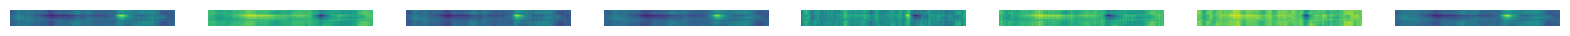

layer name:  <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7ff4729b7070>


layer name:  <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7ff46e739f60>


In [5]:
# channel importance via activation visualization
import matplotlib.pyplot as plt
from keras.models import Model

# Assume 'model' is your trained CNN model
layer_outputs = [layer.output for layer in model.layers] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_test)  # X_test should have shape (num_trials, num_electrodes, num_samples)

# Choose a sample trial for visualization
sample_trial_index = 0
for layer_name, layer_activation in zip(model.layers, activations):
    if 'conv' in layer_name.name.lower():  # Visualize activations of convolutional layers
        fig, axarr = plt.subplots(1, len(layer_activation[0, 0, 0, :]), figsize=(20, 2))
        print("layer name: ", layer_name)
        for i in range(len(layer_activation[0, 0, 0, :])):
            axarr[i].imshow(layer_activation[sample_trial_index, :, :, i], cmap='viridis')
            axarr[i].axis('off')
        plt.show()


In [ ]:
# saliency map
from keras import backend as K 
import tensorflow as tf 

# gradient of pred class with respect to input
input_img = tf.convert_to_tensor(X[0].reshape(None, 64, 656, 1)) 
print(input_img.shape)

class_output = model.output
class_index = 1 

with tf.GradientTape() as tape: 
    tape.watch(input_img)
    predictions = model(input_img)
    loss = predictions[:, class_index]

grads = tape.gradient(loss, input_img)
# grads = K.gradients(class_output, input_img)[0]

# function to compute saliency
iterate = K.function([input_img], [grads])
saliency = iterate([X_test[0]])